# Intel Image Classification (CNN - Keras)

Hello, I hope you are having a great day.

In this notebook, I will try the process of implementing CNN with Keras in order to classify images.
1. Firstly, we'll import usefull packages.
1. Then, we'll load the data, before visualize and preprocess it.
1. We'll try a simple CNN model and then we will evaluate its performances.
1. We will then use pre trained model to address this challenge aswell.

# Import Packages

In [36]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf
from tensorflow.keras import Sequential
from tqdm import tqdm
import random

In [2]:
class_names = ['layak', 'tidak-layak']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

# Loading the Data
We have to write a load_data function that load the images and the labels from the folder.

In [3]:
def get_random_crop(image, crop_height, crop_width):

    max_x = image.shape[1] - crop_width
#     print("image.shape[1], image.shape[0]:", image.shape[1], image.shape[0])
    max_y = image.shape[0] - crop_height

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)

    crop = image[y: y + crop_height, x: x + crop_width]

    return crop

In [ ]:
aug = ['normal', 'hflip', 'rot', 'zoom', 'bright']

In [139]:
def fill(img, h, w):
    return cv2.resize(img, (h, w), cv2.INTER_CUBIC)

def augmentation(img_src, method):
    img = img_src
    if(random.randint(0, 1)):
        img = cv2.flip(img, 1)

    angle = int(random.uniform(-90, 90))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))

    value = random.uniform(0.6, 1)
    h, w = img.shape[:2]
    h_taken = int(value*h)
    w_taken = int(value*w)
    h_start = random.randint(0, h-h_taken)
    w_start = random.randint(0, w-w_taken)
    img_con = img_src[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
    img = fill(img_con, h, w)

    value = random.uniform(0.5, 1.4)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return img

In [192]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['../1_WrappingData/img/data_train', '../1_WrappingData/img/data_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            print(folder)
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                try:
                    # Get the path name of the image
                    img_path = os.path.join(os.path.join(dataset, folder), file)

                    # Open and resize the img
                    image = cv2.imread(img_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#                     print("min(image.shape[0], image.shape[1]:", min(image.shape[0], image.shape[1]))
                    wh = min(image.shape[0], image.shape[1]) - 1
                    image = get_random_crop(image, wh, wh)
#                     print("shape crop:", img.shape)
                    image = cv2.resize(image, IMAGE_SIZE) 

#                     Append the image and its corresponding label to the output
                    if(dataset == '../1_WrappingData/img/data_train'):
                        for i in range(3):
                            if(i):
                                image_aug = augmentation(image, a)
                                images.append(image_aug)
                                labels.append(label)
                            else:
                                images.append(image)
                                labels.append(label)
                    else:
                        images.append(image)
                        labels.append(label)
                        
                except:
                    print("error read image", file)
                    print(image)
                    
#                 print("shape:", image.shape)
        
        arr_img = np.empty(len(images), dtype=object)
        arr_img[:] = images
        
#         print(arr_img.shape)
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [193]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading ../1_WrappingData/img/data_train
layak


 26%|████████████████████▏                                                          | 691/2700 [00:10<00:27, 73.61it/s]

error read image 1607.jpg
None


 51%|███████████████████████████████████████▌                                      | 1368/2700 [00:19<00:18, 72.01it/s]

error read image 2220.jpg
None


100%|██████████████████████████████████████████████████████████████████████████████| 2700/2700 [00:39<00:00, 68.83it/s]


tidak-layak


100%|██████████████████████████████████████████████████████████████████████████████| 2700/2700 [00:47<00:00, 57.41it/s]


Loading ../1_WrappingData/img/data_test
layak


100%|█████████████████████████████████████████████████████████████████████████████| 1149/1149 [00:07<00:00, 158.98it/s]


tidak-layak


100%|█████████████████████████████████████████████████████████████████████████████| 1149/1149 [00:05<00:00, 194.24it/s]


In [194]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [195]:
test_images, test_labels = shuffle(test_images, test_labels, random_state=25)

## Kuesioner Data

In [196]:
# import pandas as pd
# df_layak = pd.read_csv('../1_CleanData/layak-jawa timur-surabaya.csv')
# df_layak.head()

In [197]:
# df_tidak_layak = pd.read_csv('../1_CleanData/tidak layak-jawa timur-surabaya.csv')
# df_tidak_layak.head()

# Let's explore the dataset
We can ask ourselves:
* How many training and testing examples do we have ?
* What is the size of the images ?
* What is the proportion of each observed category ?

In [198]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 16194
Number of testing examples: 2298
Each image is of size: (150, 150)


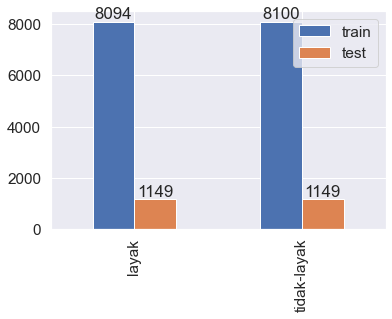

In [199]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
ax = pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
for container in ax.containers:
    ax.bar_label(container)
plt.show()

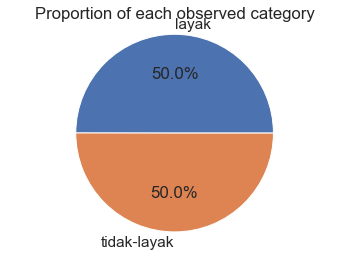

In [154]:
plt.pie(train_counts,
        explode=(0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

## Good practice: scale the data

In [200]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

## Visualize the data
We can display an image from the training set.

In [156]:
def display_image(class_names, images, labels, ind):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = ind
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

We can display a random image from the training set.

In [157]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

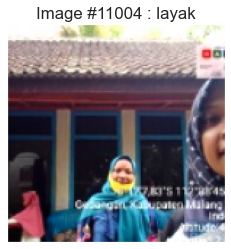

In [158]:
display_random_image(class_names, train_images, train_labels)

We can also display the first 10 images from the training set directly with a loop to get a better view

In [159]:
def display_examples(class_names, images, labels, title="Some examples of images of the dataset"):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(15,5))
    fig.suptitle(title, fontsize=16)
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i+10], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i+10]])
    plt.show()

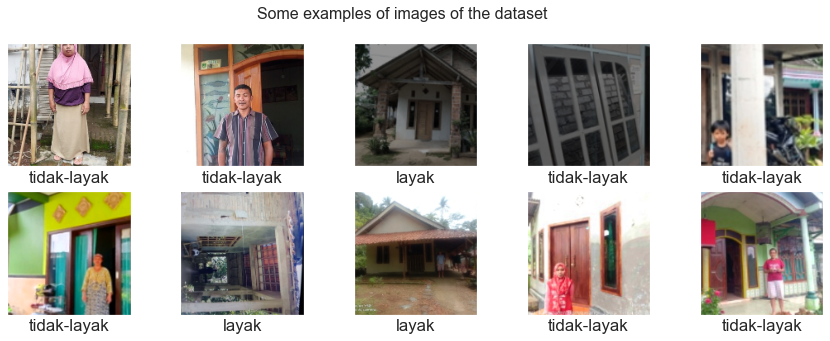

In [160]:
display_examples(class_names, train_images, train_labels)

# Data Augmentation

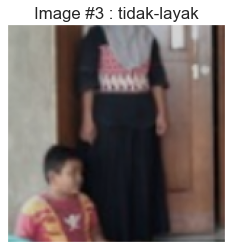

In [161]:
data_get = train_images[:10]
data_get_label = test_labels[:10]
display_image(class_names, data_get, train_labels, 3)

img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=90,
        brightness_range=(0.2,0.9))

a = img_gen.get_random_transform(data_get)

# Beginner: Simple Model Creation

Steps are:
1. Build the model,
1. Compile the model,
1. Train / fit the data to the model,
1. Evaluate the model on the testing set,
1. Carry out an error analysis of our model.

We can build an easy model composed of different layers such as:
* Conv2D: (32 filters of size 3 by 3) The features will be "extracted" from the image.
* MaxPooling2D: The images get half sized.
* Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.
* Relu  : given a value x, returns max(x, 0).
* Softmax: 6 neurons, probability that the image belongs to one of the classes.

In [201]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3), padding='same'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
#     model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
])

Then, we can compile it with some parameters such as:
* **Optimizer**: adam = RMSProp + Momentum.
What is Momentum and RMSProp ?
* Momentum = takes into account past gradient to have a better update.
* RMSProp = exponentially weighted average of the squares of past gradients.
* **Loss function**: we use sparse categorical crossentropy for classification, each images belongs to one class only

In [202]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

We fit the model to the data from the training set. The neural network will learn by itself the pattern in order to distinguish each category.

In [203]:
# train_images
# train_labels

In [204]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1)
# , callbacks=[callback]
history = model.fit(train_images, train_labels, batch_size=32, epochs=10, validation_split = 0.2)

Epoch 1/10
405/405 [==============================] - 256s 625ms/step - loss: 0.6924 - accuracy: 0.5590 - val_loss: 0.6711 - val_accuracy: 0.5949
Epoch 2/10
405/405 [==============================] - 244s 602ms/step - loss: 0.6561 - accuracy: 0.6100 - val_loss: 0.6604 - val_accuracy: 0.6033
Epoch 3/10
405/405 [==============================] - 221s 545ms/step - loss: 0.6320 - accuracy: 0.6398 - val_loss: 0.6440 - val_accuracy: 0.6172
Epoch 4/10
405/405 [==============================] - 222s 549ms/step - loss: 0.6049 - accuracy: 0.6647 - val_loss: 0.6455 - val_accuracy: 0.6227
Epoch 5/10
405/405 [==============================] - 225s 557ms/step - loss: 0.5653 - accuracy: 0.7024 - val_loss: 0.6715 - val_accuracy: 0.6261
Epoch 6/10
405/405 [==============================] - 224s 554ms/step - loss: 0.5116 - accuracy: 0.7393 - val_loss: 0.6761 - val_accuracy: 0.6400
Epoch 7/10
405/405 [==============================] - 310s 767ms/step - loss: 0.4506 - accuracy: 0.7738 - val_loss: 0.7110 -

In [205]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

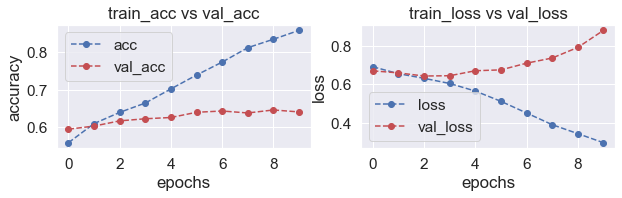

In [206]:
plot_accuracy_loss(history)

We should evaluate the model performance on test set

In [207]:
test_loss = model.evaluate(test_images, test_labels)

72/72 [==============================] - 11s 146ms/step - loss: 1.1960 - accuracy: 0.5844


In [208]:
train_loss = model.evaluate(train_images, train_labels)

507/507 [==============================] - 79s 157ms/step - loss: 0.3133 - accuracy: 0.8850


We see that we achieve 0.76 accuracy on the testing test. We got a slight underfitting :(

Let's see how the classifier is doing on random images.

In [72]:
predictions_train = model.predict(train_images)     # Vector of probabilities
# pred_labels_train = np.argmax(predictions_train, axis = 1) # We take the highest probability
pred_labels_train = ((predictions_train > 0.5)+0).ravel() # (n_images,)

pred_labels_train

array([1, 0, 0, ..., 0, 1, 1])

In [73]:
train_labels

array([1, 0, 0, ..., 0, 0, 1])

In [39]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = ((predictions > 0.5)+0).ravel() # We take the highest probability

In [40]:
test_labels

array([0, 1, 1, ..., 1, 0, 1])

In [41]:
pred_labels

array([0, 0, 0, ..., 1, 1, 0])

In [57]:
import numpy as np
unique, counts = np.unique(pred_labels, return_counts=True)
dict(zip(unique, counts))
# type(pred_labels)

{0: 1253, 1: 1045}

In [42]:
predictions

array([[0.30599463],
       [0.33683896],
       [0.01126558],
       ...,
       [0.865689  ],
       [0.8060218 ],
       [0.15381399]], dtype=float32)

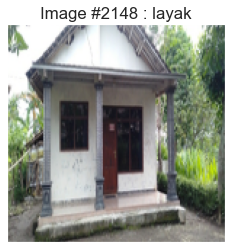

In [52]:
display_random_image(class_names, test_images, pred_labels)

In [105]:
print("pred_labels\n", pred_labels)
print("test_labels\n", test_labels)

pred_labels
 [0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1 1 1 1
 1 0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0
 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 0 0 0]
test_labels
 [1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 0 1 0 1 0
 1 0 0 0 1 0 0 1 1 0 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0
 1 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 1 0]


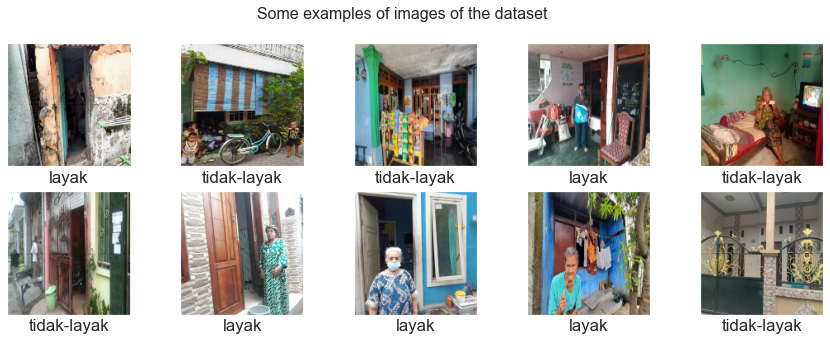

In [106]:
display_examples(class_names, test_images, pred_labels)

In [182]:
len(test_images)
test_labels

array([1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0])

In [ ]:
# load the model
model = pickle.load(open("model.pkl", "rb"))

## Error analysis

We can try to understand on which kind of images the classifier has trouble.

In [238]:
def print_predicted_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels, title)
    
    correct_indices = np.where(BOO == 1)
    correct_images = test_images[correct_indices]
    correct_labels = pred_labels[correct_indices]

    title = "Some examples of correct images by the classifier:"
    display_examples(class_names,  correct_images, correct_labels, title)


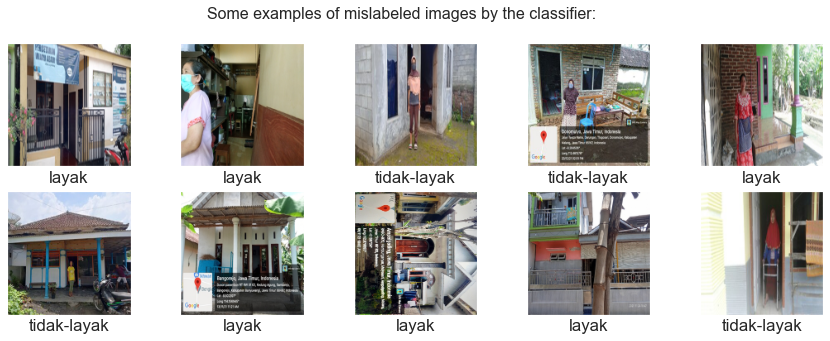

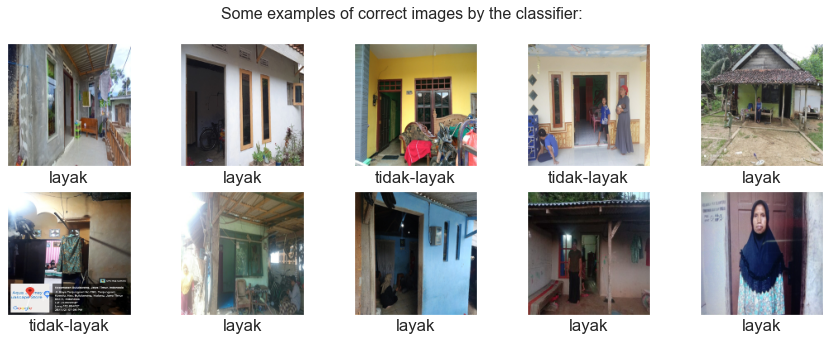

In [59]:
print_predicted_images(class_names, test_images, test_labels, pred_labels)

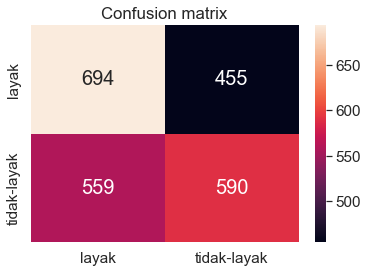

In [63]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 20}, fmt='d',
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

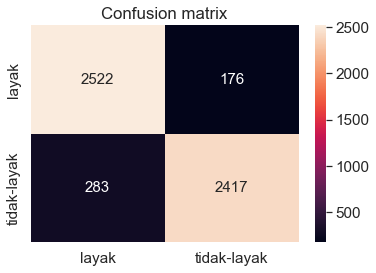

In [74]:
CM = confusion_matrix(train_labels, pred_labels_train)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 15}, fmt='d',
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [70]:
import pickle
pickle.dump(model, open("model-jatim-ori.pkl", "wb"))

INFO:tensorflow:Assets written to: ram://1c05f582-9ebf-4183-b195-43ecc6ef8db9/assets


## Conclusion: The classifier has trouble with 2 kinds of images.
It has trouble with street and buildings. Well, it can be understandable as as there are buildings in the street. 
It has also trouble with sea, glacier and moutain as well. It is hard for me to fully distinguish them.
However, it can detects forest very accurately!

**Intermediate Update January 2020**

* Feature extraction with VGG16 trained on ImageNet


* Ensemble models of Neural Networks with the features extracted from VGG

Inspired from: https://machinelearningmastery.com/model-averaging-ensemble-for-deep-learning-neural-networks/

* Fine Tuning with VGG16 trained on ImageNet

# Feature extraction with VGG ImageNet

We can extract features from VGG16.

In [163]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model_vgg = VGG16(weights='imagenet', include_top=False)

Get the features directly from VGG16

In [220]:
# train_features = model_vgg.predict(train_images)
test_features = model_vgg.predict(test_images)

## Visualize the features through PCA

In [221]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [222]:
print("numFeatures:", numFeatures)
print("train_features.shape:", train_features.shape)
print("test_features.shape:", test_features.shape)

numFeatures: 8192
train_features.shape: (16194, 4, 4, 512)
test_features.shape: (2298, 4, 4, 512)


In [167]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X) # Représentation des individus dans les nouveaux axe
C1 = C[:,0]
C2 = C[:,1]

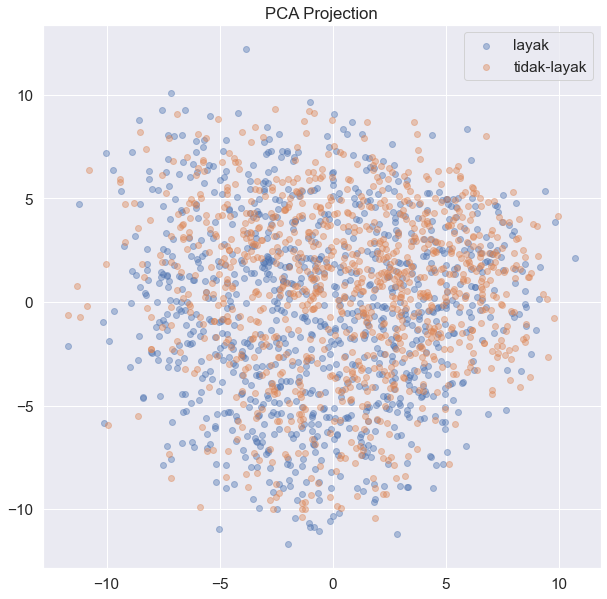

In [168]:
### Figures

plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

We can identifying clusters thanks to this PCA. The clusters correspond more or less to the labels.

We see that glacier and mountain points are very close to each other, as VGG sees them as very similar.

We see that there is no distinction between building and street.
 

## Training on top of VGG

Let's train a simple one-layer Neural Network on the features extracted from VGG.

In [169]:
model2_vgg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model2_vgg.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

checkpoint_path = "training_4/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history2 = model2_vgg.fit(train_features, train_labels, batch_size=64, epochs=15, validation_split = 0.2, 
                          callbacks=[cp_callback])

Epoch 1/15
199/203 [============================>.] - ETA: 0s - loss: 0.5972 - accuracy: 0.6725
Epoch 1: saving model to training_4\cp.ckpt
203/203 [==============================] - 8s 26ms/step - loss: 0.5968 - accuracy: 0.6726 - val_loss: 0.5542 - val_accuracy: 0.7048
Epoch 2/15
198/203 [============================>.] - ETA: 0s - loss: 0.5121 - accuracy: 0.7461
Epoch 2: saving model to training_4\cp.ckpt
203/203 [==============================] - 2s 11ms/step - loss: 0.5109 - accuracy: 0.7470 - val_loss: 0.5221 - val_accuracy: 0.7317
Epoch 3/15
200/203 [============================>.] - ETA: 0s - loss: 0.4531 - accuracy: 0.7830
Epoch 3: saving model to training_4\cp.ckpt
203/203 [==============================] - 2s 11ms/step - loss: 0.4524 - accuracy: 0.7837 - val_loss: 0.5172 - val_accuracy: 0.7416
Epoch 4/15
198/203 [============================>.] - ETA: 0s - loss: 0.4071 - accuracy: 0.8130
Epoch 4: saving model to training_4\cp.ckpt
203/203 [==============================] - 2

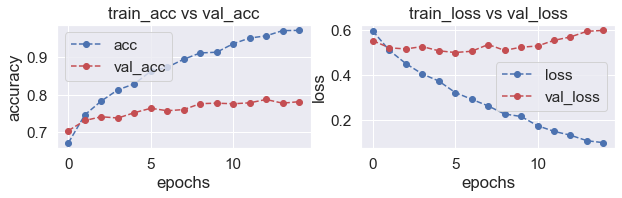

In [172]:
plot_accuracy_loss(history2)

We should get approximately 0.844 accuracy (+0.1 accuracy) over the simple ConvNet.

In [224]:
test_loss = model2_vgg.evaluate(test_features, test_labels)

72/72 [==============================] - 0s 4ms/step - loss: 1.1735 - accuracy: 0.6623


In [174]:
train_loss = model2_vgg.evaluate(train_features, train_labels)

507/507 [==============================] - 3s 5ms/step - loss: 0.1796 - accuracy: 0.9462


In [233]:
predictions_vgg = model2_vgg.predict(test_features)     # Vector of probabilities
pred_labels_vgg = ((predictions_vgg > 0.4)+0).ravel() # We take the highest probability

# display_random_image(class_names, test_images, pred_labels)

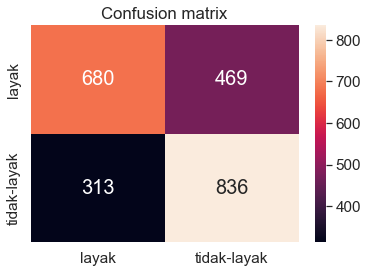

In [234]:
CM = confusion_matrix(test_labels, pred_labels_vgg)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 20}, fmt='d',
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [235]:
predictions_train_vgg = model2_vgg.predict(train_features)     # Vector of probabilities
pred_labels_train_vgg = ((predictions_train_vgg > 0.4)+0).ravel() # We take the highest probability

# display_random_image(class_names, test_images, pred_labels)

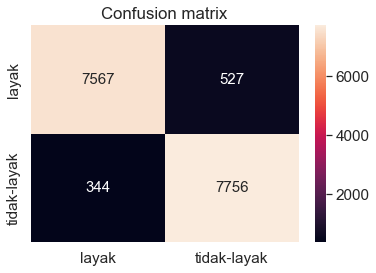

In [236]:
CM = confusion_matrix(train_labels, pred_labels_train_vgg)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 15}, fmt='d',
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

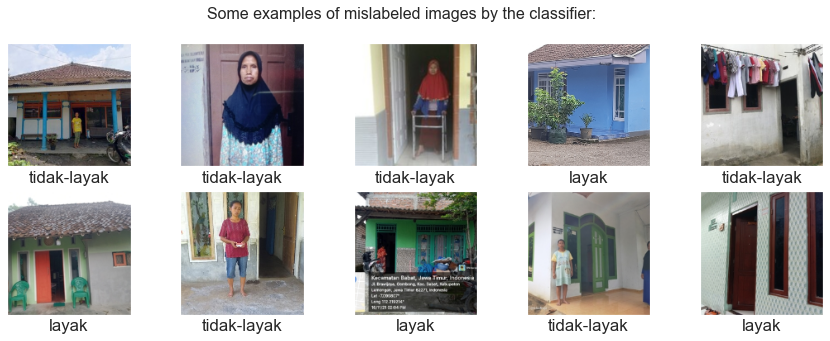

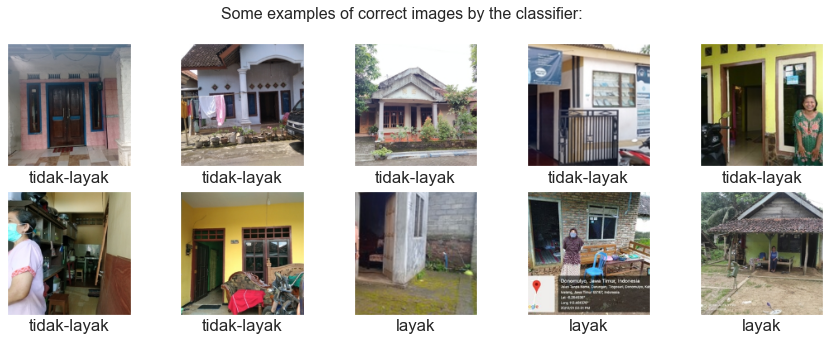

In [239]:
print_predicted_images(class_names, test_images, test_labels, pred_labels_vgg)

In [240]:
model2_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 50)                409650    
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 409,701
Trainable params: 409,701
Non-trainable params: 0
_________________________________________________________________


---
# Load Model

In [267]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = (x, y, z)),
        tf.keras.layers.Dense(50, activation=tf.nn.relu),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])

    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

    return model

model2_vgg_load = create_model()

In [268]:
model2_vgg_load.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 8192)              0         
                                                                 
 dense_14 (Dense)            (None, 50)                409650    
                                                                 
 dense_15 (Dense)            (None, 1)                 51        
                                                                 
Total params: 409,701
Trainable params: 409,701
Non-trainable params: 0
_________________________________________________________________


In [269]:
test_features.shape
# test_labels.shape

(2298, 4, 4, 512)

In [270]:
test_loss_load = model2_vgg_load.evaluate(test_features, test_labels)

72/72 [==============================] - 1s 4ms/step - loss: 0.7080 - accuracy: 0.5117


In [271]:
model2_vgg_load.load_weights(checkpoint_path)
model2_vgg_load.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 8192)              0         
                                                                 
 dense_14 (Dense)            (None, 50)                409650    
                                                                 
 dense_15 (Dense)            (None, 1)                 51        
                                                                 
Total params: 409,701
Trainable params: 409,701
Non-trainable params: 0
_________________________________________________________________


In [272]:
test_loss_load = model2_vgg_load.evaluate(test_features, test_labels)

72/72 [==============================] - 1s 7ms/step - loss: 1.1735 - accuracy: 0.6623


In [284]:
test_features[:1].shape

(1, 4, 4, 512)

In [282]:
model2_vgg_load.predict(test_features[:1])
# test_features[:2].shape

array([[0.11144939]], dtype=float32)

In [86]:
!pip install fastapi uvicorn

     ---------------------------------------- 54.6/54.6 kB 1.4 MB/s eta 0:00:00
     ---------------------------------------- 57.0/57.0 kB ? eta 0:00:00
     ---------------------------------------- 63.3/63.3 kB 3.3 MB/s eta 0:00:00
     ---------------------------------------- 1.9/1.9 MB 3.2 MB/s eta 0:00:00
     ---------------------------------------- 80.6/80.6 kB 4.4 MB/s eta 0:00:00


# Ensemble Neural Networks

In [137]:
np.random.seed(seed=1997)
# Number of estimators
n_estimators = 10
# Proporition of samples to use to train each training
max_samples = 0.8

max_samples *= n_train
max_samples = int(max_samples)

We define n_estimators Neural Networks. 

Each Neural Network will be trained on random subsets of the training dataset. Each subset contains max_samples samples.

In [138]:
models = list()
random = np.random.randint(50, 100, size = n_estimators)

for i in range(n_estimators):
    
    # Model
    model = tf.keras.Sequential([ tf.keras.layers.Flatten(input_shape = (x, y, z)),
                                # One layer with random size
                                    tf.keras.layers.Dense(random[i], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
                                ])
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Store model
    models.append(model)

In [139]:
histories = []

for i in range(n_estimators):
    # Train each model on a bag of the training data
    train_idx = np.random.choice(len(train_features), size = max_samples)
    histories.append(models[i].fit(train_features[train_idx], train_labels[train_idx], batch_size=128, epochs=10, validation_split = 0.1))

Epoch 1/10
3/3 [==============================] - 1s 103ms/step - loss: 9.2110 - accuracy: 0.4079 - val_loss: 27.4879 - val_accuracy: 0.5484
Epoch 2/10
3/3 [==============================] - 0s 39ms/step - loss: 15.8432 - accuracy: 0.6715 - val_loss: 39.8110 - val_accuracy: 0.4516
Epoch 3/10
3/3 [==============================] - 0s 44ms/step - loss: 20.0646 - accuracy: 0.5632 - val_loss: 4.3413 - val_accuracy: 0.7742
Epoch 4/10
3/3 [==============================] - 0s 41ms/step - loss: 7.0473 - accuracy: 0.6859 - val_loss: 1.3295 - val_accuracy: 0.8710
Epoch 5/10
3/3 [==============================] - 0s 41ms/step - loss: 0.7648 - accuracy: 0.9206 - val_loss: 14.9545 - val_accuracy: 0.5484
Epoch 6/10
3/3 [==============================] - 0s 43ms/step - loss: 1.3849 - accuracy: 0.8881 - val_loss: 3.2481 - val_accuracy: 0.7419
Epoch 7/10
3/3 [==============================] - 0s 42ms/step - loss: 0.1301 - accuracy: 0.9819 - val_loss: 0.3936 - val_accuracy: 0.9677
Epoch 8/10
3/3 [=====

We aggregate each model individual predictions to form a final prediction.

In [140]:
predictions = []
for i in range(n_estimators):
    predictions.append(models[i].predict(test_features))
    
predictions = np.array(predictions)
predictions = predictions.sum(axis = 0)
pred_labels = predictions.argmax(axis=1)

We should improve our result as we have a lower variance.

In [141]:
from sklearn.metrics import accuracy_score
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.4742268041237113


# Fine Tuning VGG ImageNet

In [155]:
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [156]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

In [241]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0) # get the input shape of desired layer
layer_input = Input(shape = (9, 9, 512)) # a new input tensor to be able to feed the desired layer
# https://stackoverflow.com/questions/52800025/keras-give-input-to-intermediate-layer-and-get-final-output

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(2,activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)

In [242]:
new_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                  metrics = [tf.keras.metrics.BinaryAccuracy(name="accuracy", dtype=None, threshold=0.5)])

In [243]:
new_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 9, 9, 512)]       0         
                                                                 
 block5_conv1 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv2 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv3 (Conv2D)       multiple                  2359808   
                                                                 
 block5_pool (MaxPooling2D)  multiple                  0         
                                                                 
 conv2d_30 (Conv2D)          (None, 2, 2, 64)          294976    
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 1, 1, 64)         0   

In [247]:
history = new_model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10


ValueError: in user code:

    File "C:\Users\Agus Zainal Arifin\anaconda3\envs\nevin\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Agus Zainal Arifin\anaconda3\envs\nevin\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Agus Zainal Arifin\anaconda3\envs\nevin\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Agus Zainal Arifin\anaconda3\envs\nevin\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Agus Zainal Arifin\anaconda3\envs\nevin\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Agus Zainal Arifin\anaconda3\envs\nevin\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_6" is incompatible with the layer: expected shape=(None, 9, 9, 512), found shape=(None, 150, 150, 3)


In [245]:
history.history

{'loss': [1.1267977952957153,
  0.7001156210899353,
  0.6931981444358826,
  0.6931790113449097,
  0.6931717991828918,
  0.6931641697883606,
  0.693157970905304,
  0.6931524872779846,
  0.693149983882904,
  0.6931488513946533,
  0.693148136138916,
  0.6931476593017578,
  0.6931476593017578,
  0.6931474804878235,
  0.6931473612785339],
 'accuracy': [0.4318181872367859,
  0.5324675440788269,
  0.5422077775001526,
  0.48051947355270386,
  0.5324675440788269,
  0.5357142686843872,
  0.5324675440788269,
  0.5389610528945923,
  0.5129870176315308,
  0.4577922224998474,
  0.5,
  0.48051947355270386,
  0.5,
  0.47727271914482117,
  0.49025973677635193],
 'val_loss': [0.7052609920501709,
  0.6931710243225098,
  0.6931675672531128,
  0.6931611895561218,
  0.6931585669517517,
  0.6931537985801697,
  0.6931506395339966,
  0.6931489109992981,
  0.6931480765342712,
  0.6931475400924683,
  0.6931473016738892,
  0.6931472420692444,
  0.6931471228599548,
  0.6931470632553101,
  0.6931470632553101],
 'va

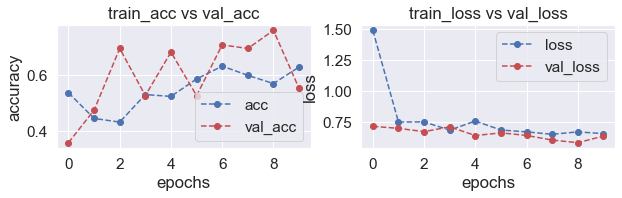

In [162]:
plot_accuracy_loss(history)

In [163]:
from sklearn.metrics import accuracy_score

predictions = new_model.predict(test_features)    
pred_labels = np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.5360824742268041


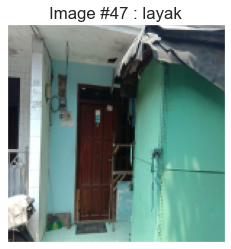

In [164]:
display_random_image(class_names, test_images, pred_labels)

In [165]:
pred_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)